In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.stats import linregress
import os
import json
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
# Definir parámetros de tiempo desde el archivo .env
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

In [3]:
def obtener_archivos_corr_length(directorio, patron="corr_length_real_inverse_mean"):
    if not os.path.exists(directorio):
        print(f"❌ Directorio no encontrado: {directorio}")
        return []
    
    archivos = [
        os.path.join(directorio, archivo)
        for archivo in os.listdir(directorio)
        if patron in archivo and archivo.endswith(".txt") and os.path.isfile(os.path.join(directorio, archivo))
    ]
    return archivos
    if not os.path.exists(directorio):
        print(f"❌ Directorio no encontrado: {directorio}")
        return []
    
    archivos = [
        os.path.join(directorio, archivo)
        for archivo in os.listdir(directorio)
        if patron in archivo and archivo.endswith(".txt") and os.path.isfile(os.path.join(directorio, archivo))
    ]
    return archivos

In [4]:
def obtener_tipo_correlacion(file_path):
    """ Extrae el tipo de correlación del nombre del archivo """
    base_name = os.path.basename(file_path)
    partes = base_name.split("_")
    if len(partes) >= 4:
        return partes[-2] + "_" + partes[-1].split(".")[0]  # Extraer las últimas 3 letras
    return "Desconocido"

In [5]:
# Definir rutas de los directorios
ruta_strong_mu0 = '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0'
ruta_strong_mu1 = '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1'
ruta_weak_mu0 = '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0'
ruta_weak_mu1 = '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1'

In [6]:
# Lista de correlaciones
correlations = ["c_s", "c_i", "s_i", "c_c", "s_s", "i_i"]

# Rutas de los directorios
rutas = {
    'strong_mu0': '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0',
    'strong_mu1': '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1',
    'weak_mu0':   '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0',
    'weak_mu1':   '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1',
}

for nombre_ruta, path in rutas.items():
    print(f"\nProcesando: {nombre_ruta} ({path})")

    for corr in correlations:
        all_data = []
        file_shapes = []

        for block in range(1, 11):
            filename = os.path.join(path, f"corr_length_real_inverse_nb_{block}_{corr}.txt")
            try:
                data = np.loadtxt(filename)

                if data.ndim == 1:
                    data = data.reshape(-1, 2)

                all_data.append(data)
                file_shapes.append((filename, data.shape))

            except Exception as e:
                print(f"  ⚠️  No se pudo leer {filename}: {e}")

        if len(all_data) > 0:
            # Usar la forma del primer archivo como referencia
            ref_shape = all_data[0].shape
            archivos_filtrados = [d for d in all_data if d.shape == ref_shape]
            archivos_excluidos = [f for f, shape in file_shapes if shape != ref_shape]

            if len(archivos_filtrados) < len(all_data):
                print(f"  ⚠️  Se excluyeron {len(all_data) - len(archivos_filtrados)} archivos por forma desigual.")
                for excluido in archivos_excluidos:
                    print(f"     - Excluido: {excluido}")

            if len(archivos_filtrados) >= 2:
                stacked = np.stack(archivos_filtrados, axis=0)
                mean_data = np.mean(stacked, axis=0)

                output_filename = os.path.join(path, f"corr_length_real_inverse_mean_{corr}.txt")
                np.savetxt(output_filename, mean_data)
                print(f"  ✅ Promedio guardado: {output_filename}")
            else:
                print(f"  ❌ No suficientes arc")
        else:
            print(f"  ❌ No se encontraron archivos válidos para: {corr}")



Procesando: strong_mu0 (/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0)
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_s.txt
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_i.txt
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_s_i.txt
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_c.txt
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_s_s.txt
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_i_i.txt

Procesando: strong_mu1 (/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1)
  ✅ Promedio guardado: /media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_in

In [7]:
def plot_correlation_loglog(title):
    resultados_regresion = {}

    files_to_plot = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }

    for label, file_list in files_to_plot.items():
        if not file_list:
            print(f"🔍 {label}: lista vacía, se omite.")
            continue

        for file_path in file_list:
            plt.figure(figsize=(7, 6))
            try:
                data = np.loadtxt(file_path)

                if data.ndim == 1 or (data.ndim == 2 and data.shape[1] < 2):
                    print(f"⚠️ {file_path}: no tiene al menos dos columnas, se omite.")
                    continue

                # Asegurar que data tenga dos dimensiones
                if data.ndim == 1:
                    data = data.reshape(-1, 2)

                x, y = data[:, 0], data[:, 1]

                # Filtrar valores válidos
                valid_indices = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
                x, y = x[valid_indices], y[valid_indices]

                if len(x) <= 1:
                    print(f"{file_path}: No hay suficientes datos válidos para la regresión log-log.")
                    continue

                correlacion_tipo = obtener_tipo_correlacion(file_path)

                # Gráfico de puntos
                plt.loglog(x, y, marker='o', linestyle='-', label=label)

                # Ajuste log-log
                log_x = np.log(x)
                log_y = np.log(y)

                if np.all(np.isfinite(log_x)) and np.all(np.isfinite(log_y)):
                    slope, intercept, _, _, _ = linregress(log_x, log_y)

                    resultados_regresion[file_path] = {
                        "tipo_correlacion": correlacion_tipo,
                        "m": round(slope, 6),
                        "b": round(intercept, 6),
                        "funcion": f"g(r) ≈ e^{intercept:.6f} * r^{slope:.6f}"
                    }

                    fit_y = np.exp(intercept) * x ** slope
                    plt.loglog(x, fit_y, linestyle='--', label=f"Fit: g(r) ≈ e^{intercept:.4f} * r^{slope:.4f}")

                plt.xlabel("Distancia (r) [log]")
                plt.ylabel("g(r) [log]")
                plt.title(f"{title} - {correlacion_tipo} - Log-Log")
                plt.grid(True, which="both", linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Error al cargar {file_path}: {e}")

    with open("resultados_regresion.json", "w") as file:
        json.dump(resultados_regresion, file, indent=4)

    return resultados_regresion

In [8]:
def plot_correlation_with_fit(selected_labels, title, fit_results_file="resultados_regresion.json"):
    # Cargar los resultados de la regresión desde el archivo JSON
    with open(fit_results_file, "r") as file:
        fit_results = json.load(file)
    
    # Diccionario de archivos disponibles para graficar
    available_files = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }
    
    # Filtrar los archivos a graficar según la selección del usuario
    files_to_plot = [(label, available_files[label]) for label in selected_labels if label in available_files]
    
    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas seleccionadas)
    num_plots = min(len(files) for _, files in files_to_plot)

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for index, (label, file_list) in enumerate(files_to_plot):
            file_path = file_list[i]
            print(file_path)
            correlacion_tipo = obtener_tipo_correlacion(file_path)
            try:
                data = np.loadtxt(file_path)
                x, y = data[:, 0], data[:, 1]
                color = f"C{index}"  # Asignar color consistente por índice de archivo
                plt.plot(x, y, linestyle='dotted', color=color, label=f"{label} ({correlacion_tipo})")
                
                # Graficar la función de aproximación si está en los resultados
                if file_path in fit_results:
                    m = fit_results[file_path]["m"]
                    b = fit_results[file_path]["b"]
                    xi = 1 / m if m != 0 else np.inf  # Longitud de correlación ξ
                    fit_y = np.exp(b) * x ** m
                    plt.plot(x, fit_y, linestyle='--', color=color, 
                             label=f"Fit: ξ(t) ≈ e^{b:.6f} * r^{m:.6f}, ξ ≈ {xi:.6f}")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Distancia (r)", fontsize=12)  # Etiqueta del eje X
        plt.ylabel("g(r)", fontsize=12)  # Etiqueta del eje Y
        plt.title(f"{title} - {correlacion_tipo}", fontsize=14)  # Título de la gráfica con tipo de correlación
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)  # Añadir cuadrícula con líneas punteadas
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()

In [9]:
def plot_fits_only(selected_labels, title, fit_results_file="resultados_regresion.json"):
    # Cargar los resultados de la regresión desde el archivo JSON
    with open(fit_results_file, "r") as file:
        fit_results = json.load(file)
    
    # Diccionario de archivos disponibles para graficar
    available_files = {
        "Strong μ=0": corr_length_strong_mu0,
        "Strong μ=1": corr_length_strong_mu1,
        "Weak μ=0": corr_length_weak_mu0,
        "Weak μ=1": corr_length_weak_mu1
    }
    
    # Filtrar los archivos a graficar según la selección del usuario
    files_to_plot = [(label, available_files[label]) for label in selected_labels if label in available_files]
    
    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas seleccionadas)
    num_plots = min(len(files) for _, files in files_to_plot)

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for index, (label, file_list) in enumerate(files_to_plot):
            file_path = file_list[i]
            correlacion_tipo = obtener_tipo_correlacion(file_path)
            try:
                data = np.loadtxt(file_path)
                x = data[:, 0]
                color = f"C{index}"  # Asignar color consistente por índice de archivo
                
                # Graficar solo la función de aproximación si está en los resultados
                if file_path in fit_results:
#                    m = fit_results[file_path]["m"]
                    m = 0.5
                    b = fit_results[file_path]["b"]
                    fit_y = np.exp(b) * x ** m
#                    plt.plot(x, fit_y, linestyle='--', color=color, label=f"{label}  ξ(t) ≈ e^{b:.6f} * r^{m:.6f}")
                    plt.plot(x, fit_y, linestyle='--', color=color, label=f"{label}  ξ(t) ≈ e^{b:.6f} * r^0.5")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Tiempo 't'", fontsize=12)  # Etiqueta del eje X
        plt.ylabel(" ξ(t)", fontsize=12)  # Etiqueta del eje Y
        plt.title(f"{title} - {correlacion_tipo}", fontsize=14)  # Título de la gráfica con tipo de correlación
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)  # Añadir cuadrícula con líneas punteadas
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()

In [10]:
# Obtener listas de archivos desde cada directorio
corr_length_strong_mu0 = obtener_archivos_corr_length(ruta_strong_mu0)
corr_length_strong_mu1 = obtener_archivos_corr_length(ruta_strong_mu1)
corr_length_weak_mu0 = obtener_archivos_corr_length(ruta_weak_mu0)
corr_length_weak_mu1 = obtener_archivos_corr_length(ruta_weak_mu1)

In [11]:
corr_length_strong_mu1

['/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_c_c.txt',
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_c_i.txt',
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_c_s.txt',
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_i_i.txt',
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_s_i.txt',
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1/corr_length_real_inverse_mean_s_s.txt']

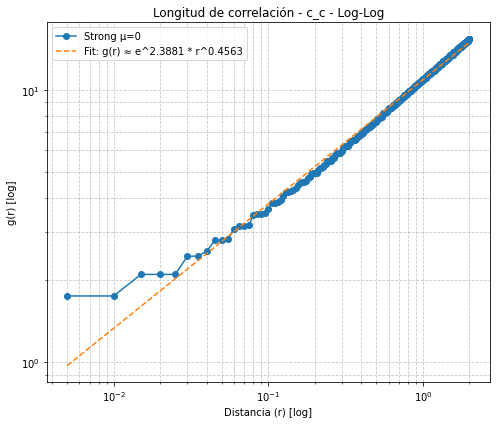

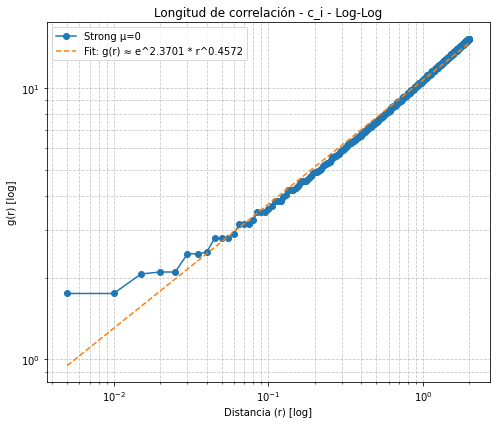

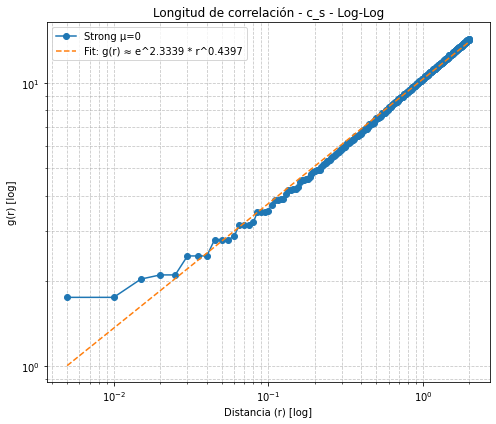

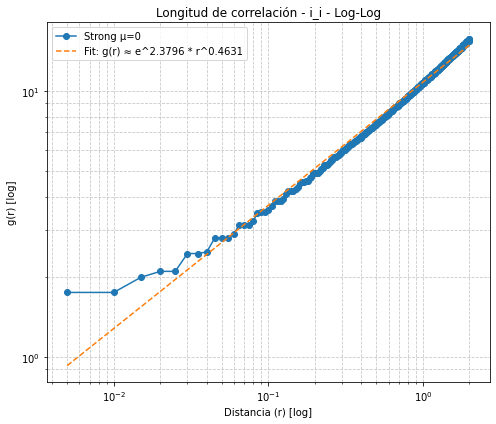

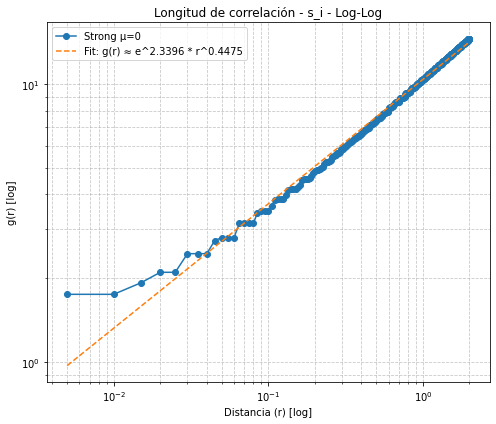

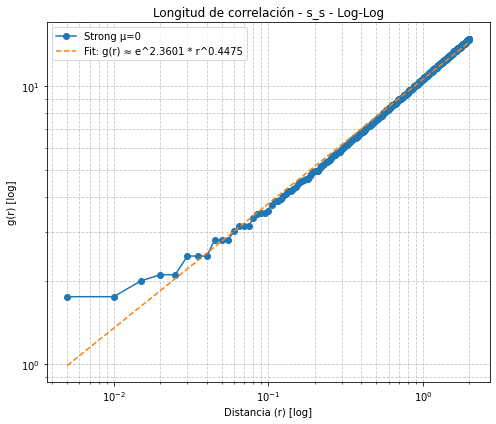

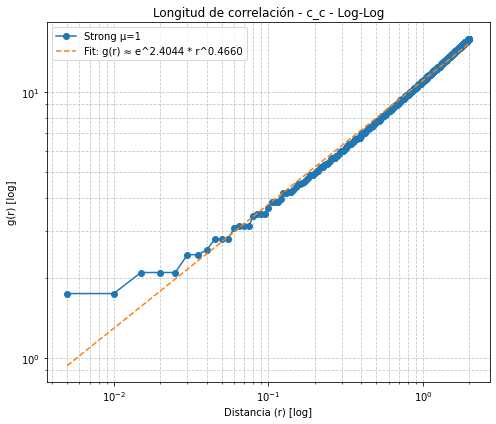

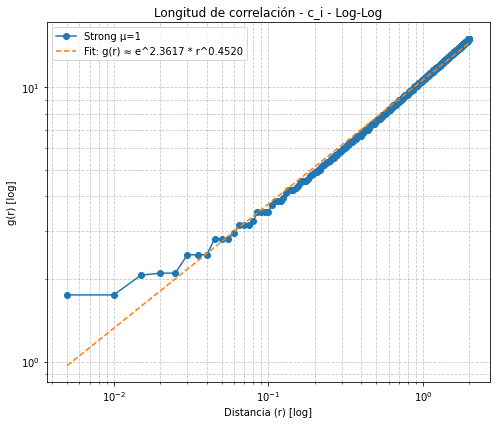

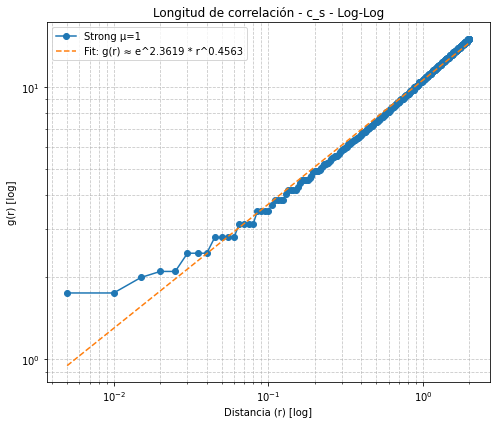

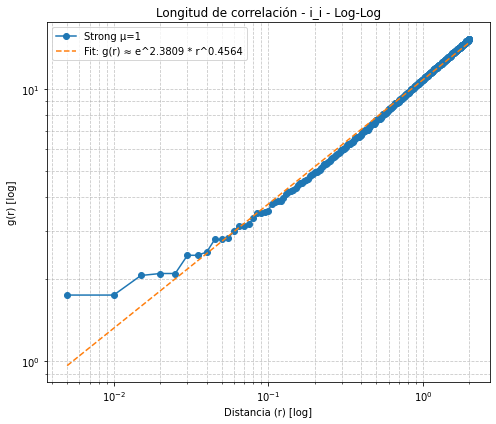

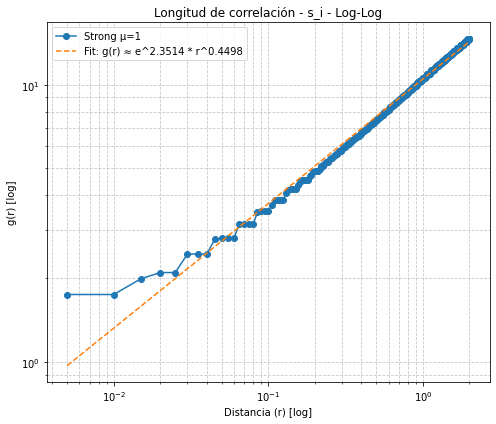

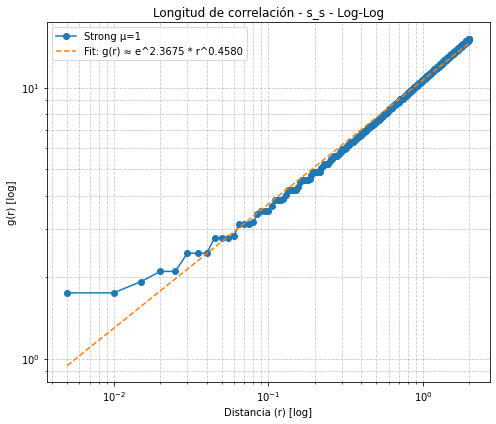

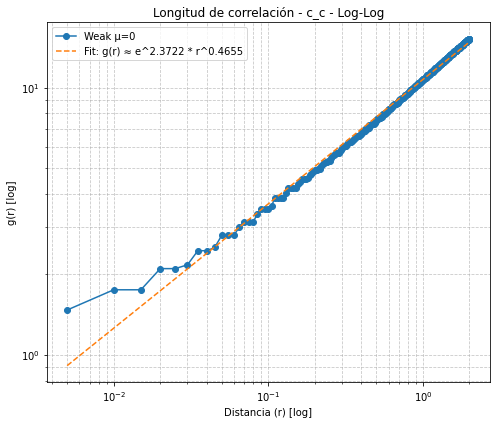

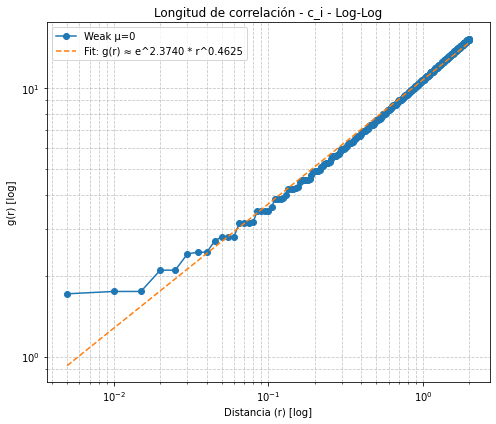

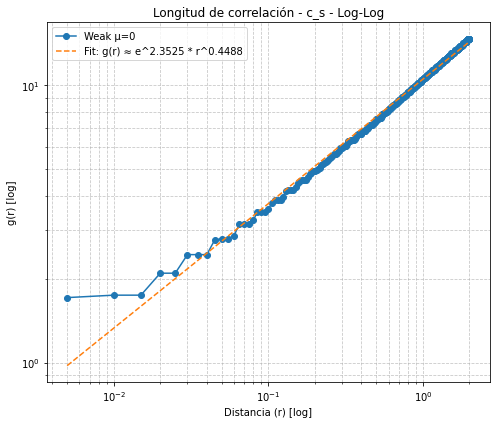

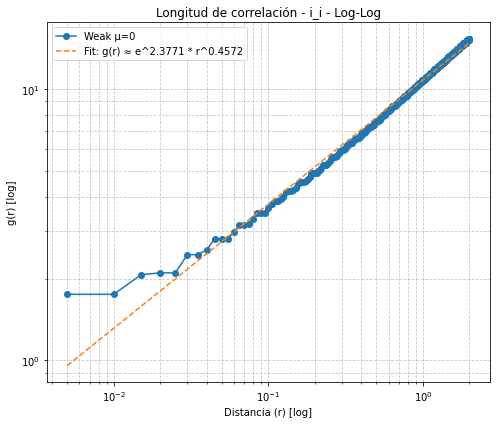

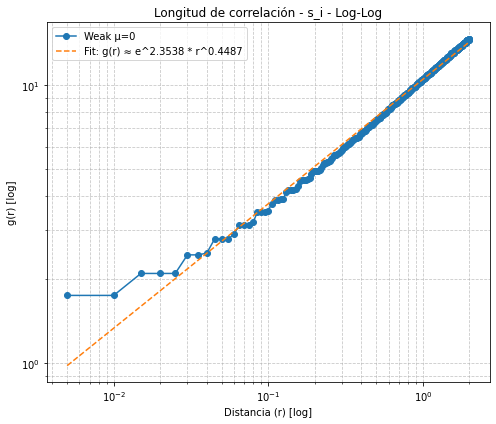

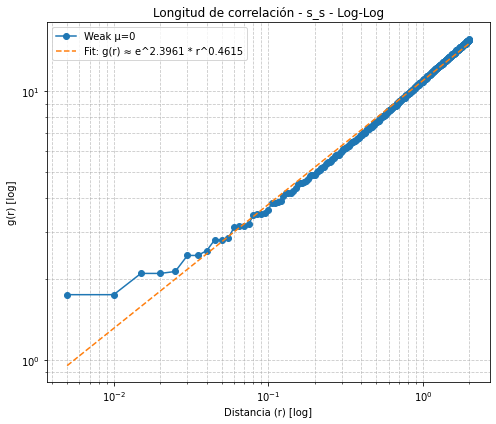

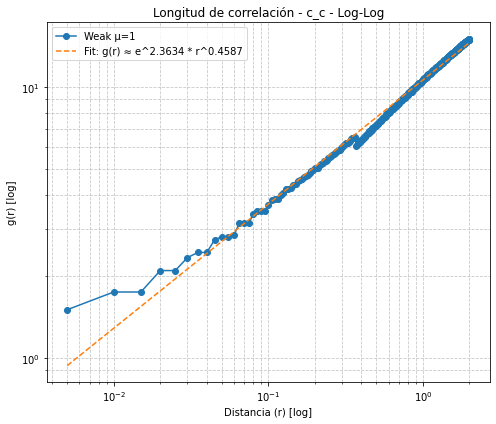

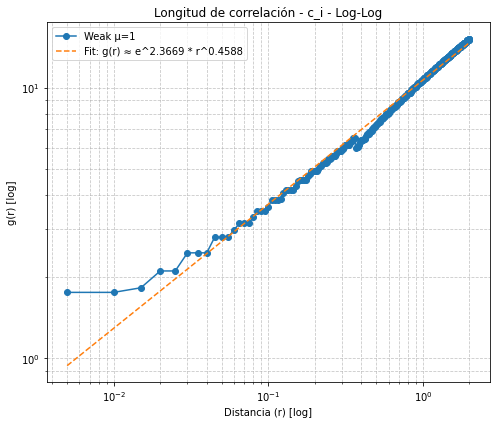

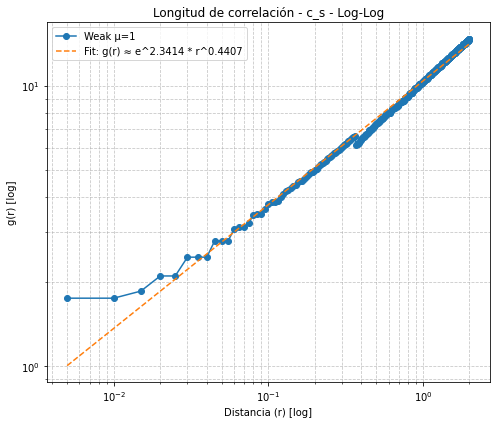

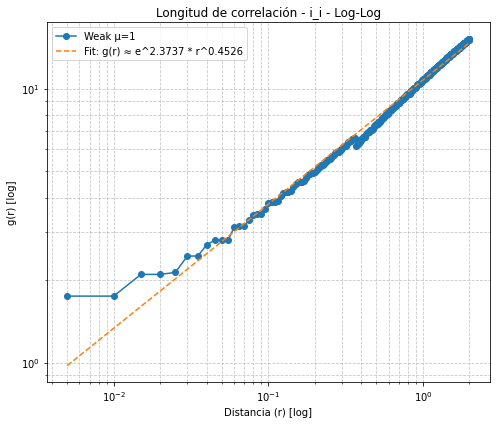

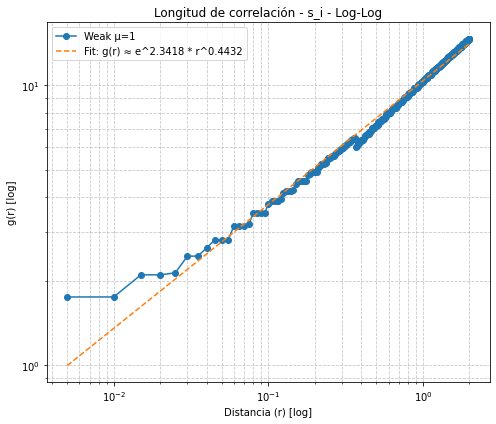

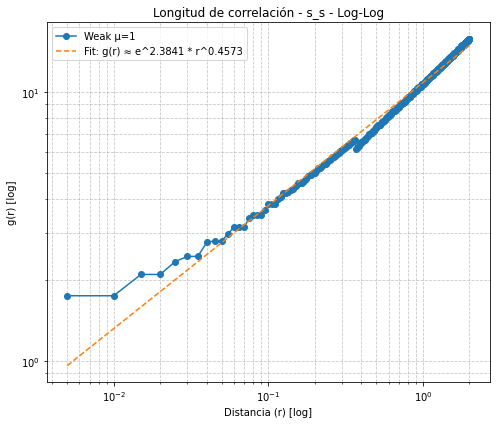

{'/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_c.txt': {'tipo_correlacion': 'c_c',
  'm': 0.456321,
  'b': 2.388132,
  'funcion': 'g(r) ≈ e^2.388132 * r^0.456321'},
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_i.txt': {'tipo_correlacion': 'c_i',
  'm': 0.457244,
  'b': 2.370094,
  'funcion': 'g(r) ≈ e^2.370094 * r^0.457244'},
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_c_s.txt': {'tipo_correlacion': 'c_s',
  'm': 0.439664,
  'b': 2.333943,
  'funcion': 'g(r) ≈ e^2.333943 * r^0.439664'},
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_i_i.txt': {'tipo_correlacion': 'i_i',
  'm': 0.463075,
  'b': 2.379632,
  'funcion': 'g(r) ≈ e^2.379632 * r^0.463075'},
 '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0/corr_length_real_inverse_mean_s_i.txt': {'tipo_correlacion': 's_i',
  'm': 0.447454,
  'b'

In [12]:
# Llamar a la función de graficación con las listas de archivos y un título
plot_correlation_loglog("Longitud de correlación")

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_c_c.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_c_c.txt


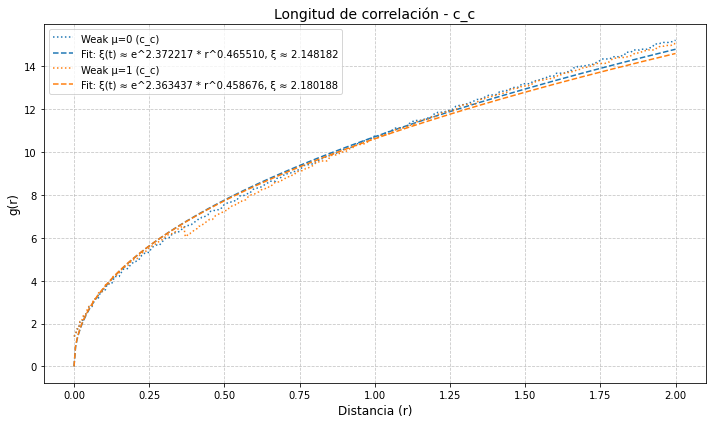

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_c_i.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_c_i.txt


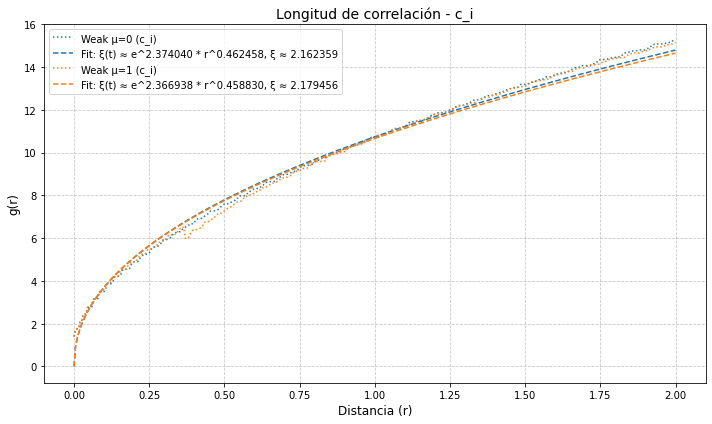

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_c_s.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_c_s.txt


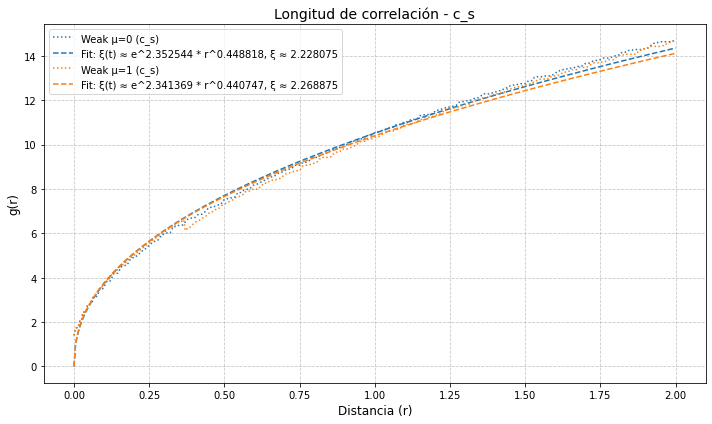

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_i_i.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_i_i.txt


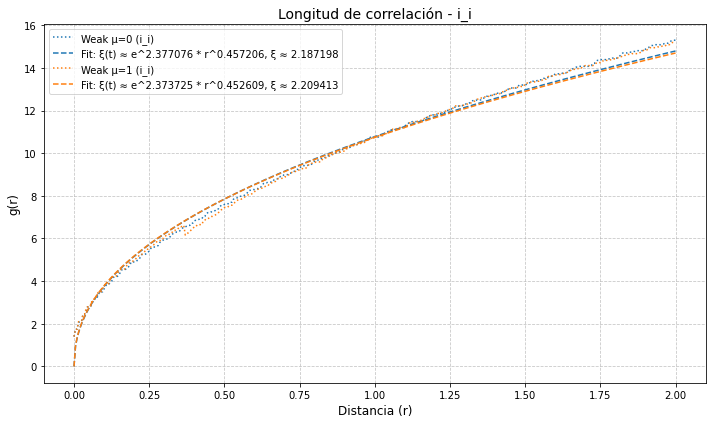

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_s_i.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_s_i.txt


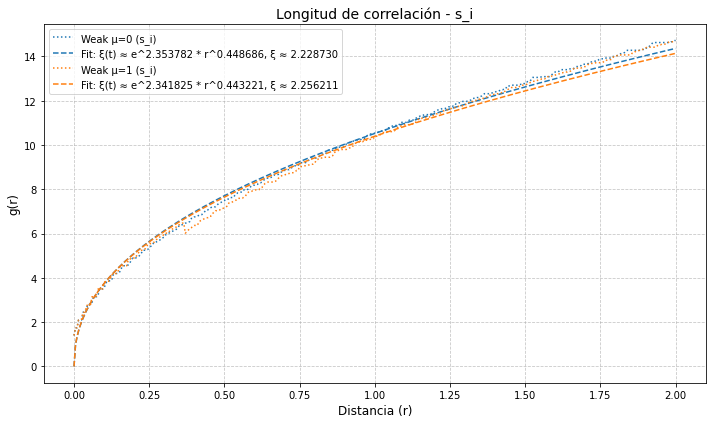

/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0/corr_length_real_inverse_mean_s_s.txt
/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1/corr_length_real_inverse_mean_s_s.txt


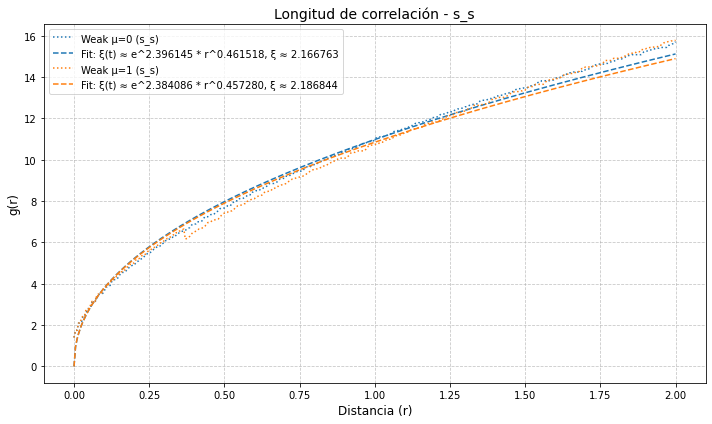

In [13]:
# # Ejemplo de uso: seleccionar qué conjuntos graficar
#selected_labels = ["Weak μ=0", "Weak μ=1"]
#selected_labels = ["Weak μ=1", "Weak μ=0", "Strong μ=0", "Strong μ=1"]
selected_labels = ["Weak μ=0", "Weak μ=1"]
plot_correlation_with_fit(selected_labels, "Longitud de correlación")

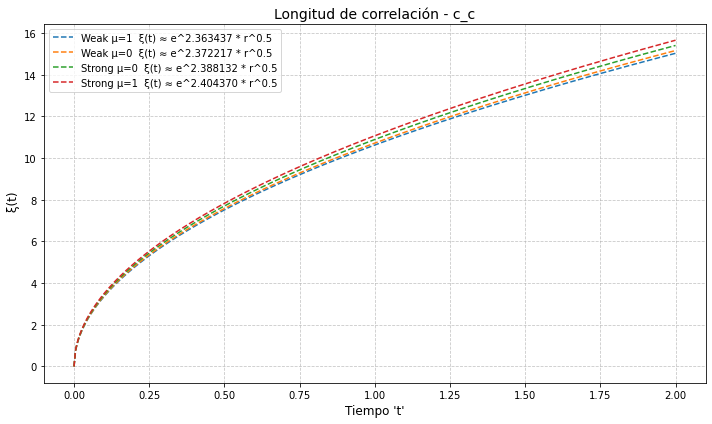

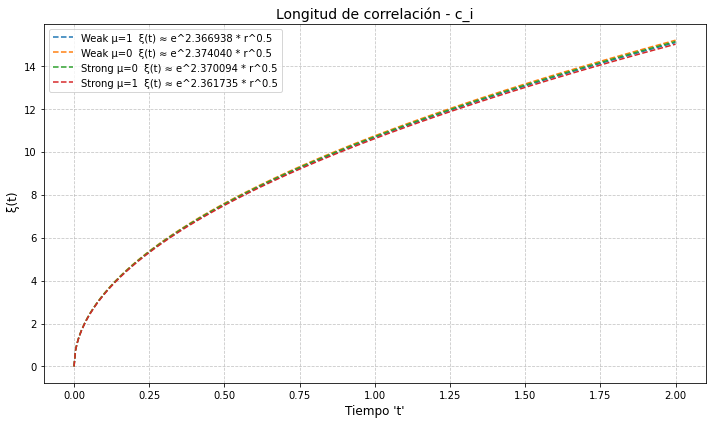

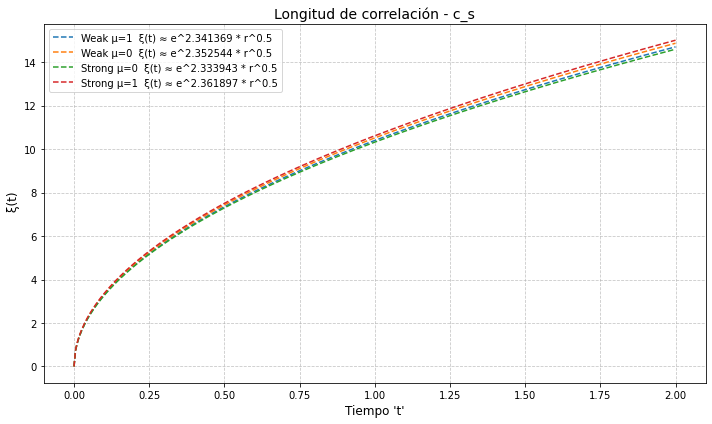

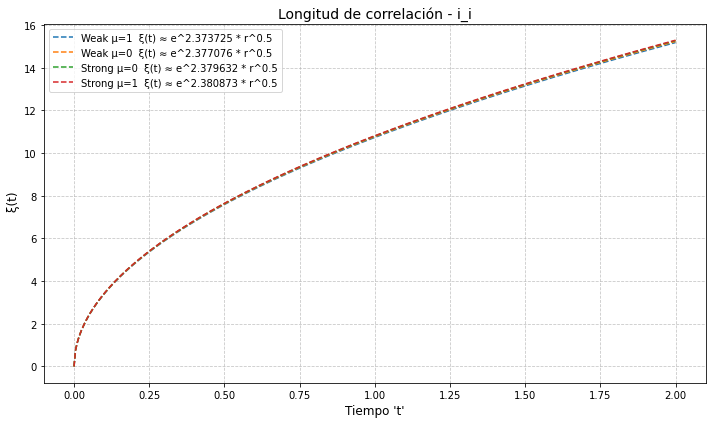

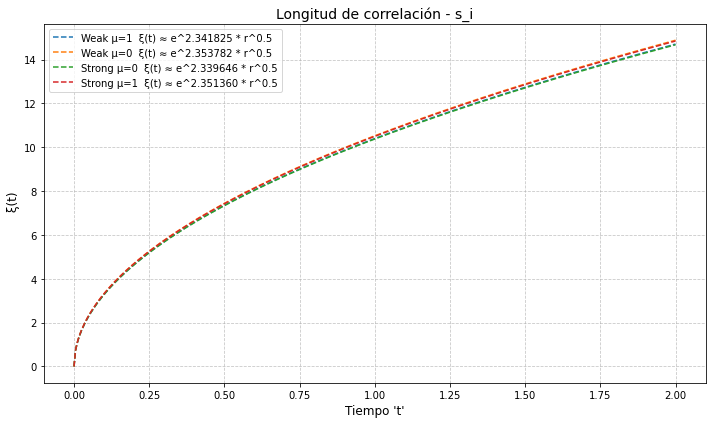

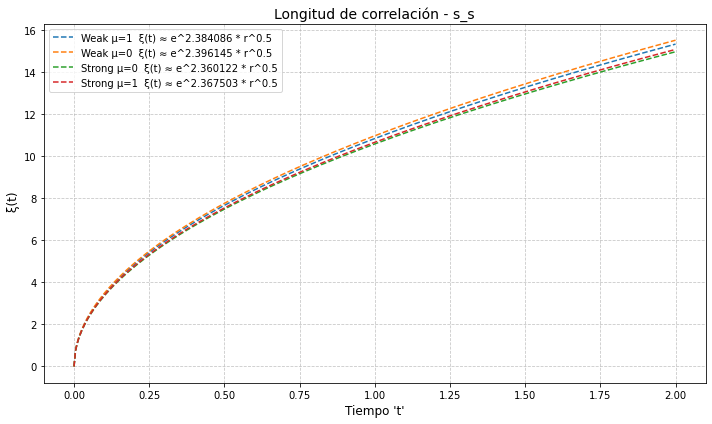

In [14]:
# Ejemplo de uso: seleccionar qué conjuntos graficar
# selected_labels = ["Strong μ=0", "Weak μ=0", "Strong μ=1", "Weak μ=1"]
selected_labels = ["Weak μ=1", "Weak μ=0", "Strong μ=0", "Strong μ=1"]
plot_fits_only(selected_labels, "Longitud de correlación")